In [6]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
! unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [9]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [10]:
train = get_training_data('chest_xray/chest_xray/train')
test = get_training_data('chest_xray/chest_xray/test')
val = get_training_data('chest_xray/chest_xray/val')

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



<ipython-input-9-f7c995ea1462>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [11]:
# l = []
# for i in train:
#     if(i[1] == 0):
#         l.append("Pneumonia")
#     else:
#         l.append("Normal")
# sns.set_style('darkgrid')
# sns.countplot(l)

Text(0.5, 1.0, 'NORMAL')

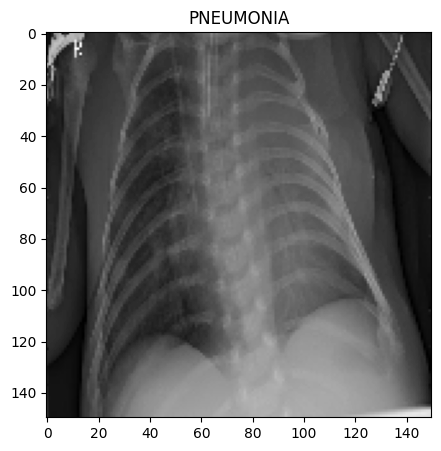

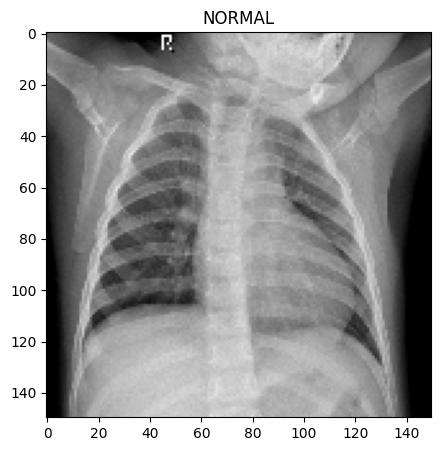

In [12]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [13]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [14]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [15]:
# resize data for deep learning
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [16]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [17]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       256       
 hNormalization)                                                 
                                                        

In [18]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [19]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [])

Epoch 1/12
163/163 [==============================] - 415s 3s/step - loss: 0.5459 - accuracy: 0.8468 - val_loss: 17.0746 - val_accuracy: 0.5000
Epoch 2/12
163/163 [==============================] - 406s 2s/step - loss: 0.2640 - accuracy: 0.8976 - val_loss: 13.0535 - val_accuracy: 0.5000
Epoch 3/12
163/163 [==============================] - 388s 2s/step - loss: 0.2153 - accuracy: 0.9237 - val_loss: 50.6702 - val_accuracy: 0.5000
Epoch 4/12
163/163 [==============================] - 400s 2s/step - loss: 0.1953 - accuracy: 0.9329 - val_loss: 29.2477 - val_accuracy: 0.5000
Epoch 5/12
163/163 [==============================] - 398s 2s/step - loss: 0.1815 - accuracy: 0.9363 - val_loss: 5.4266 - val_accuracy: 0.5000
Epoch 6/12
163/163 [==============================] - 394s 2s/step - loss: 0.1626 - accuracy: 0.9433 - val_loss: 54.4475 - val_accuracy: 0.5000
Epoch 7/12
163/163 [==============================] - 400s 2s/step - loss: 0.1563 - accuracy: 0.9484 - val_loss: 7.3781 - val_accuracy: 0

In [38]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 11s 563ms/step - loss: 0.3225 - accuracy: 0.8766
Loss of the model is -  0.32247504591941833
20/20 [==============================] - 11s 565ms/step - loss: 0.3225 - accuracy: 0.8766
Accuracy of the model is -  87.66025900840759 %


In [39]:
model.save('my_model.keras')

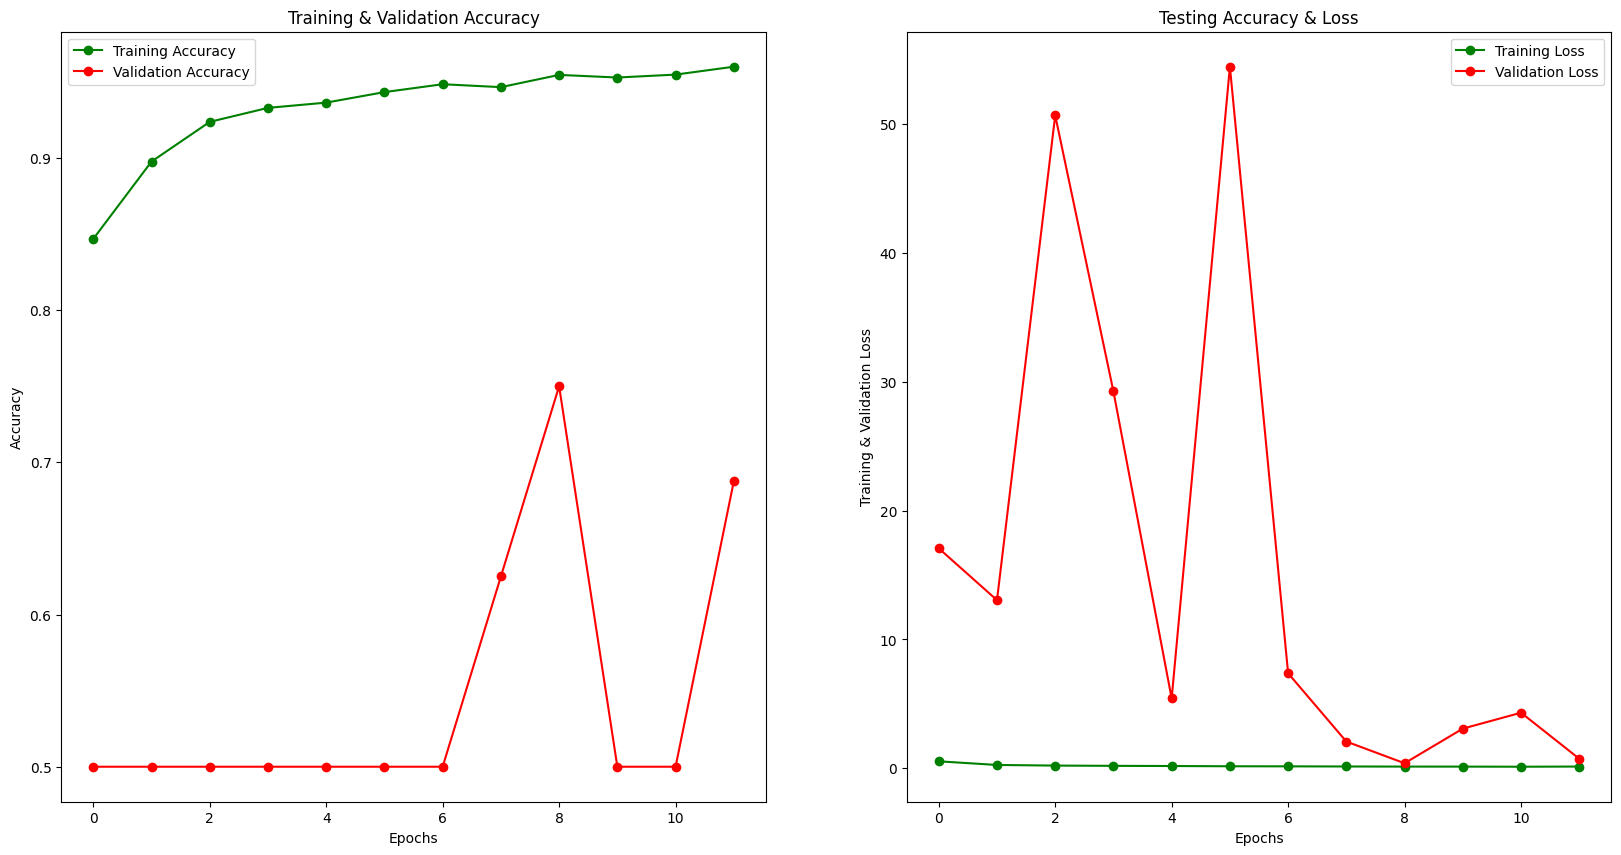

In [21]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [40]:
# predictions = np.argmax(model.predict(x_test, batch_size=16),axis=1)
predictions = (model.predict(x_test) > 0.5).astype("int32")
# predictions = predictions.reshape(1,-1)[0]
print(predictions.shape)
predictions[:15]

20/20 [==============================] - 15s 747ms/step
(624, 1)


array([[0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int32)

In [41]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.91      0.89      0.90       390
   Normal (Class 1)       0.82      0.85      0.84       234

           accuracy                           0.88       624
          macro avg       0.87      0.87      0.87       624
       weighted avg       0.88      0.88      0.88       624



In [42]:
cm = confusion_matrix(y_test,predictions)
cm

array([[347,  43],
       [ 34, 200]])

In [43]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<Axes: >

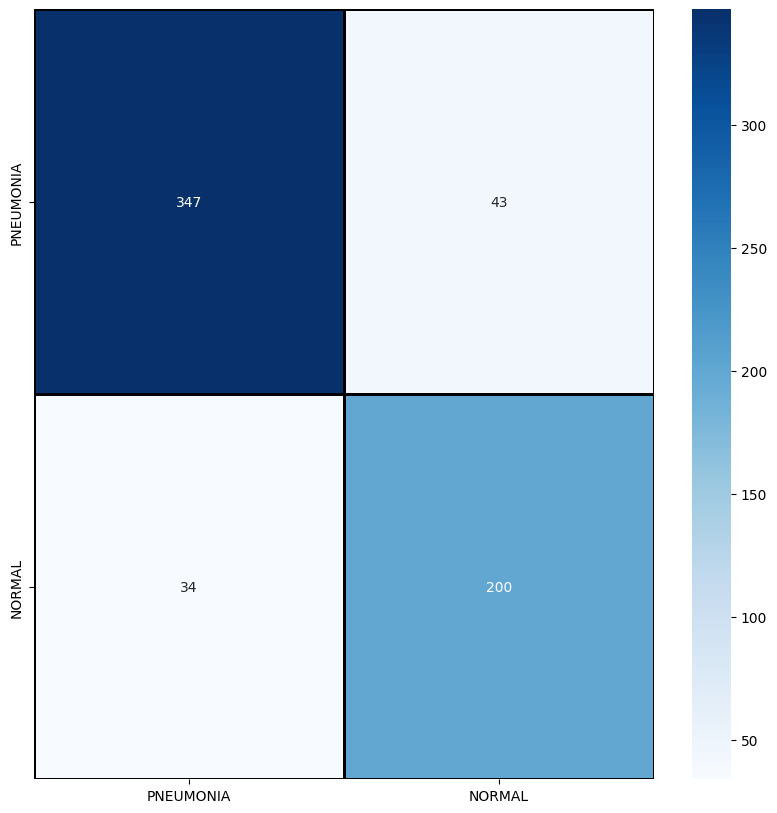

In [44]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [45]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

<ipython-input-46-3b0e8ec19e68>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)


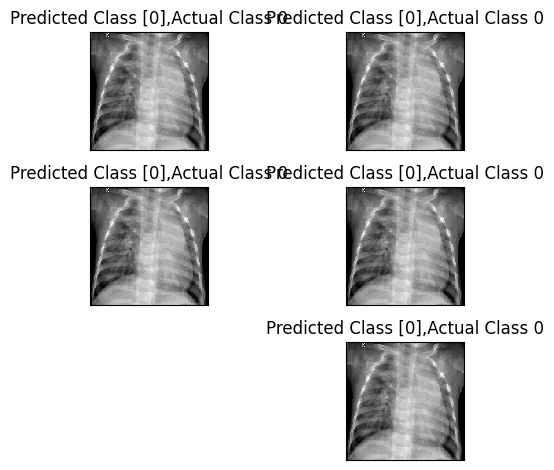

In [46]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

<ipython-input-47-d863d2b73908>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)


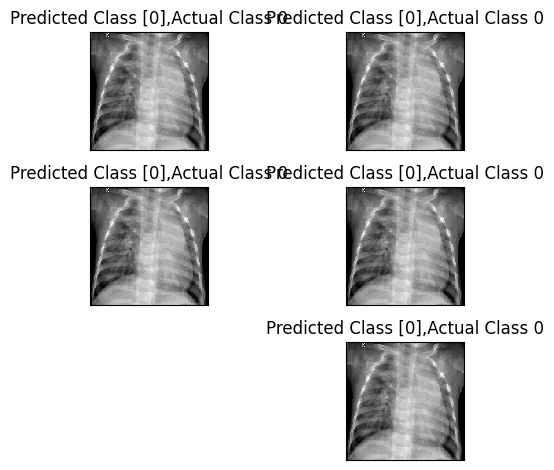

In [47]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

In [ ]:
# import os
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization

# test_dir = os.path.join('./chest_xray/test')

# train_dir = os.path.join('./chest_xray/train')

# val_dir = os.path.join('./chest_xray/val')

# train_datagen = ImageDataGenerator(
#     rescale=1/255,
#     featurewise_center=False,  # set input mean to 0 over the dataset
#     samplewise_center=False,  # set each sample mean to 0
#     featurewise_std_normalization=False,  # divide inputs by std of the dataset
#     samplewise_std_normalization=False,  # divide each input by its std
#     zca_whitening=False,  # apply ZCA whitening
#     rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
#     zoom_range = 0.2, # Randomly zoom image
#     width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#     height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#     horizontal_flip = True,  # randomly flip images
#     vertical_flip=False)
# validation_datagen = ImageDataGenerator(
#     rescale=1/255,
#     featurewise_center=False,  # set input mean to 0 over the dataset
#     samplewise_center=False,  # set each sample mean to 0
#     featurewise_std_normalization=False,  # divide inputs by std of the dataset
#     samplewise_std_normalization=False,  # divide each input by its std
#     zca_whitening=False,  # apply ZCA whitening
#     rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
#     zoom_range = 0.2, # Randomly zoom image
#     width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#     height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#     horizontal_flip = True,  # randomly flip images
#     vertical_flip=False)
# test_datagen = ImageDataGenerator(rescale=1/255)

# train_generator = train_datagen.flow_from_directory(
#         train_dir,
#         target_size=(150, 150),
#         batch_size=128,
#         # Since you use binary_crossentropy loss, you need binary labels
#         class_mode='binary',
#         shuffle=True)

# val_generator = train_datagen.flow_from_directory(
#         val_dir,
#         target_size=(150, 150),
#         batch_size=128,
#         # Since you use binary_crossentropy loss, you need binary labels
#         class_mode='binary',
#         shuffle=True)

In [ ]:
# print(list(train_generator.class_indices.keys()))
# labels = [list(train_generator.class_indices.keys())[i] for i in train_generator.labels]
# print(labels)

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# sns.set_style('darkgrid')
# sns.countplot(x = labels)

In [ ]:
# train_generator[0][0].shape

In [ ]:
# model = Sequential()
# model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,3)))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# model.add(Dropout(0.1))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# model.add(Flatten())
# model.add(Dense(units = 128 , activation = 'relu'))
# model.add(Dropout(0.2))
# model.add(Dense(units = 1 , activation = 'sigmoid'))
# model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
# model.summary()

In [ ]:
# from tensorflow.keras.callbacks import ReduceLROnPlateau
# learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
# history = model.fit(
#     train_generator,
#     steps_per_epoch=41,
#     epochs=15,
#     verbose=1,
#     validation_data = val_generator,
#     validation_steps=1,
#     callbacks = [learning_rate_reduction])

In [ ]:
# model.save('model_pneumonia.h5')